In [208]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [209]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [210]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [211]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [212]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [213]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [214]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [215]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [216]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [217]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [218]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Работа с пропусками

In [220]:
# из информации в предыдущей ячейке столбцов с пропусками два: lat и lng
# я приняла решение удалить эти столбцы

data = data.drop(columns=['lat', 'lng'])

# Преобразование признаков

In [221]:
# выделю страну отеля в отдельный признак из закодирую его

data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1])

data['country'] = data['country'].astype('category')
data['country_n'] = data['country'].cat.codes

data.head(3)



,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,country_n
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,4
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,5


In [222]:
# преобразую колонку с датой в формат datetime и выделю месяц


data['review_date'] = pd.to_datetime(data['review_date'])

data['month'] = data['review_date'].dt.month
data['month'] = data['month'].astype('int32')

data['month']


0          7
1         12
2         11
3         10
4          5
          ..
515733     4
515734     2
515735     2
515736     5
515737     8
Name: month, Length: 515738, dtype: int32

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [224]:
# проработаю признак с тэгами. Сначала посмотрю сколько всего уникальных тэгов

hotels_tag = data.copy()

def tags(tag_col):
    tag_col = tag_col[2: -2]
    res = tag_col.strip().split(' \', \' ')
    return res

hotels_tag['tags_n'] = hotels_tag['tags'].apply(tags)

hotels_tag = hotels_tag.explode('tags_n')

hotels_tag['tags_n'].describe()

count          2356592
unique            2428
top       Leisure trip
freq            417778
Name: tags_n, dtype: object

In [225]:
# создам топ 20 тэгов

count_tags = hotels_tag.groupby('tags_n')['tags_n'].count()
count_tags.sort_values(ascending = False).head(20)



tags_n
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Name: tags_n, dtype: int64

In [226]:
# создам новые признаки из наиболее популярных тэгов у гостей отелей (выберу из них наиболее информативные)
# добавлю признаки про количество гостей, количество проведённых ночей и цель поездки

data['leisure_trip_tag'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['Couple_tag'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['Stayed 1 night_tag'] = data['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
data['Stayed 2 nights_tag'] = data['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)
data['Solo traveler_tag'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['Stayed 3 nights_tag'] = data['tags'].apply(lambda x: 1 if 'Stayed 3 nights' in x else 0)
data['Business trip_tag'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
data['Group_tag'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)
data['with_children_tag'] = data['tags'].apply(lambda x: 1 if ('Family with young children' in x) 
                                                        or ('Family with older children' in x) else 0)
data['Stayed 4 nights_tag'] = data['tags'].apply(lambda x: 1 if 'Stayed 4 nights' in x else 0)

data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,leisure_trip_tag,Couple_tag,Stayed 1 night_tag,Stayed 2 nights_tag,Solo traveler_tag,Stayed 3 nights_tag,Business trip_tag,Group_tag,with_children_tag,Stayed 4 nights_tag
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,1,0,1,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,1,0,1,0,0,0,0,1,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0,1,0,1,0,1,0,0,0


In [227]:
# поработаю с признаком страны рецензента
# выберу 30 самых частовстречающихся стран, остальные обозначу как "другие"

rev_nat = data.reviewer_nationality.value_counts()
rev_nat_list = rev_nat[:30].index

def rev(country):
    if country in rev_nat_list:
        return country
    else:
        return 'other'
    
data['reviewer_nationality'] = data['reviewer_nationality'].apply(rev)
data.reviewer_nationality.value_counts()



 United Kingdom               245246
other                          61634
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 

In [228]:
# из признака 'days_since_review' выделю число

data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(re.findall(r'\d+', x)[0])).astype('int16')

In [229]:
# поработаю с признаками позитивные и негативные отзывы
# выведу топ 20 самых частых фраз

neg = data.negative_review.value_counts()
neg_list = neg[:20].index
print(neg_list)

pos = data.positive_review.value_counts()
pos_list = pos[:20].index
print(pos_list)

Index(['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
       ' ', ' N a', ' Breakfast', ' Small room', ' Location', ' Everything',
       ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints',
       ' Price', ' Nothing really ', ' Nil'],
      dtype='object')
Index(['No Positive', ' Location', ' Everything', ' location', ' Nothing',
       ' The location', ' Great location', ' Good location', ' Location ',
       ' Everything ', ' Breakfast', ' Friendly staff', ' Staff',
       ' Excellent location', ' Great location ', ' Location and staff',
       ' everything', ' Good location ', ' Nothing ', ' Comfy bed'],
      dtype='object')


In [230]:
# проведу анализ "тональности" отзывов с помощью библиотеки SentimentIntensityAnalyzer
# этот способ я увидела у одного из пользователей Kaggle и решила попробовать применить

#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk.corpus import stopwords
#import string
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

negative_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.negative_review.tolist()]
positive_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.positive_review.tolist()]


In [231]:
data['n_negative'] = [x['neg'] for x in negative_polarity_scores]
data['n_neutral'] = [x['neu'] for x in negative_polarity_scores]
data['n_positive'] = [x['pos'] for x in negative_polarity_scores]
data['n_compound'] = [x['compound'] for x in negative_polarity_scores]

data['p_negative'] = [x['neg'] for x in positive_polarity_scores]
data['p_neutral'] = [x['neu'] for x in positive_polarity_scores]
data['p_positive'] = [x['pos'] for x in positive_polarity_scores]
data['p_compound'] = [x['compound'] for x in positive_polarity_scores]

# Нормализация признаков

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [233]:
# удалю признаки, на которых модель не сможет обучаться

data.drop(['review_date', 'country', 'hotel_address', 'hotel_name', 'reviewer_nationality',
          'negative_review', 'positive_review', 'country', 'tags'], axis = 1, inplace=True)

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int16  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   country_n                                   515738 non-null  int8   
 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

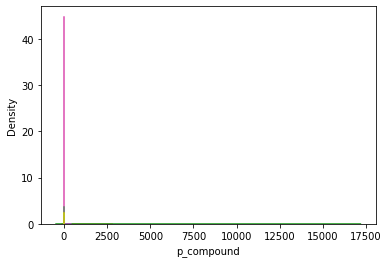

In [93]:
# проверю часть признаков на нормальность визуально 

import seaborn as sb

sb.distplot(data['review_total_negative_word_counts'])
sb.distplot(data['additional_number_of_scoring'])
sb.distplot(data['total_number_of_reviews'])
sb.distplot(data['total_number_of_reviews_reviewer_has_given'])
sb.distplot(data['review_total_positive_word_counts'])
sb.distplot(data['average_score'])

plt.show()

In [237]:
# проведу нормализацию признаков
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()

# создам список имен столбцов
col_names = ['review_total_negative_word_counts', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 
             'review_total_positive_word_counts', 'additional_number_of_scoring', 'month', 'average_score']


# кодирую исходный датасет
df_mm = mm_scaler.fit_transform(data[col_names])
df_mm = pd.DataFrame(df_mm, columns=col_names) 
data = data.drop(col_names, axis=1) # удалю исходные столбцы
data = pd.concat([data, df_mm], axis=1) # добавлю новые


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

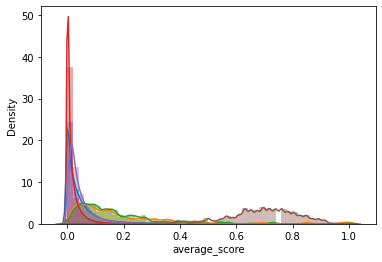

In [95]:
# проверю изменения

sb.distplot(data['review_total_negative_word_counts'])
sb.distplot(data['additional_number_of_scoring'])
sb.distplot(data['total_number_of_reviews'])
sb.distplot(data['total_number_of_reviews_reviewer_has_given'])
sb.distplot(data['review_total_positive_word_counts'])
sb.distplot(data['average_score'])
plt.show()

# Анализ мультиколлинеарности

<AxesSubplot:>

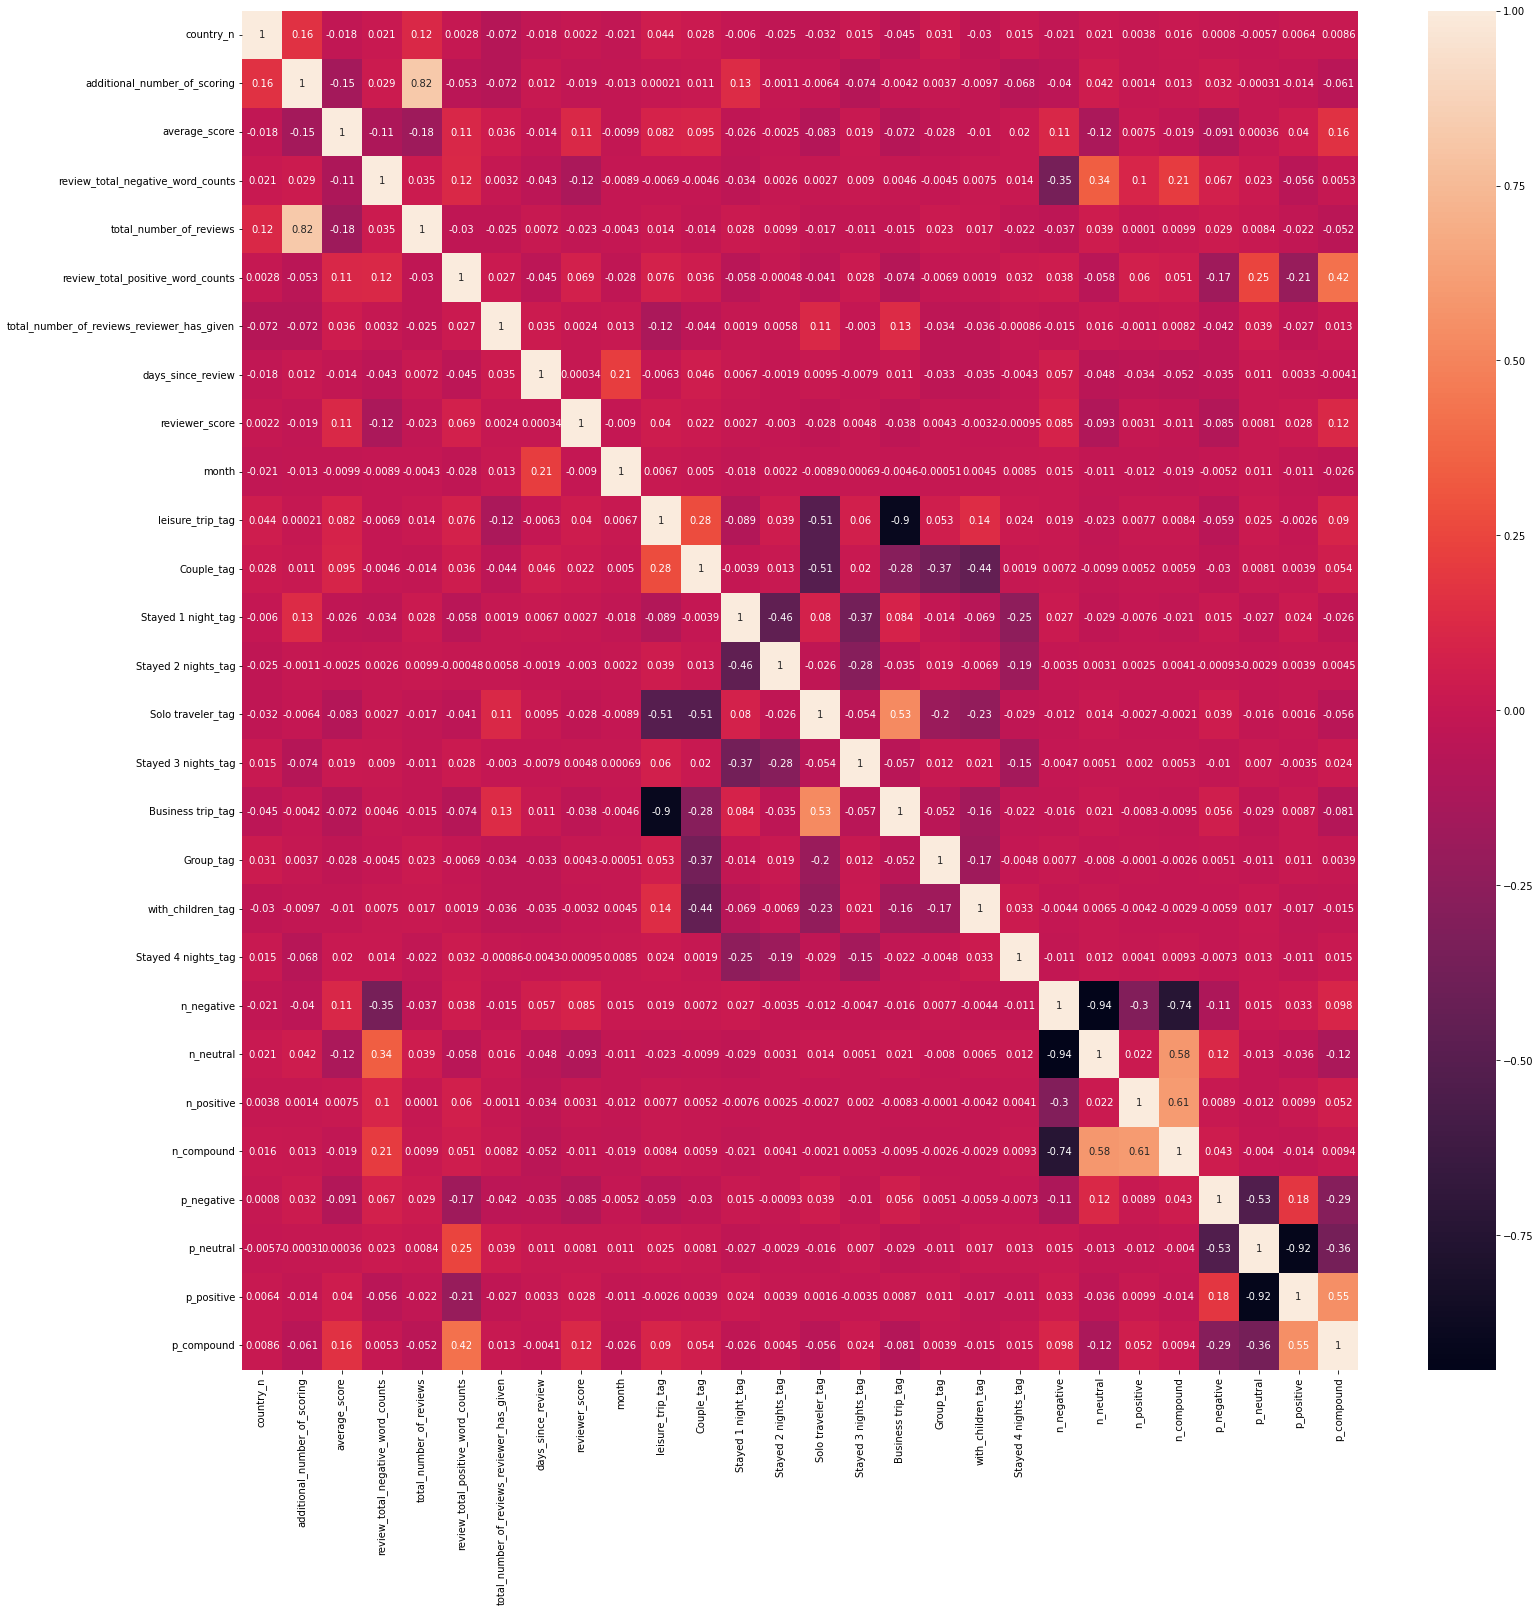

In [96]:
# построю визуализацию корреляции

plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [55]:
# в более ранних ноутбуках я удаляла сильно скореллированные признаки, 
# но это ухудшало результаты предсказаний, поэтому я приняла решение этого не делать

#data.drop(['additional_number_of_scoring', 'leisure_trip_tag', 'n_negative', 'p_positive'], axis = 1, inplace=True)

In [238]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [239]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [240]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 28), (386803, 28), (386803, 27), (309442, 27), (77361, 27))

In [241]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [242]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [243]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [244]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


MAPE: 0.8809670589832083


<AxesSubplot:>

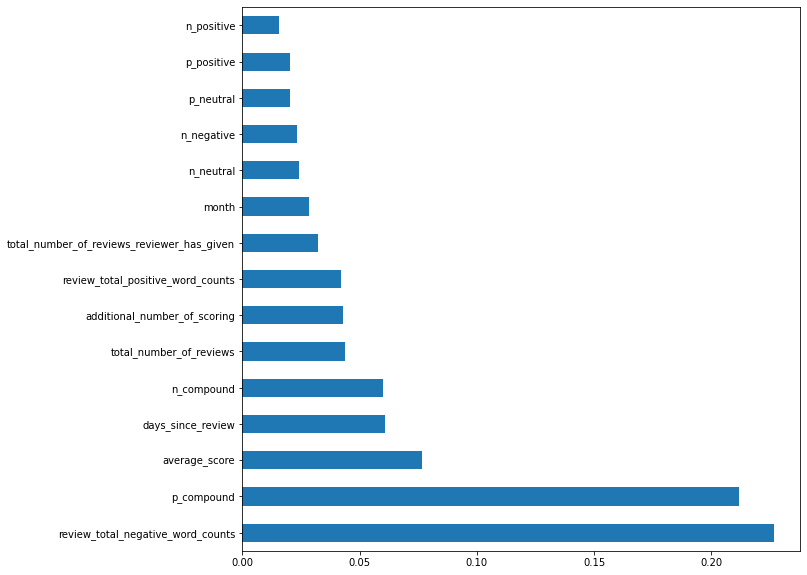

In [245]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [246]:
test_data.sample(10)

,days_since_review,reviewer_score,country_n,leisure_trip_tag,Couple_tag,Stayed 1 night_tag,Stayed 2 nights_tag,Solo traveler_tag,Stayed 3 nights_tag,Business trip_tag,...,p_neutral,p_positive,p_compound,review_total_negative_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,review_total_positive_word_counts,additional_number_of_scoring,month,average_score
99651,269,0.0,5,1,1,0,0,0,1,0,...,0.533,0.467,0.8360,0.039216,0.019186,0.000000,0.032911,0.024618,0.909091,0.934783
76488,541,0.0,3,1,0,1,0,1,0,0,...,1.000,0.000,0.0000,0.004902,0.067240,0.011299,0.043038,0.107423,0.090909,0.760870
104988,573,0.0,0,1,0,0,0,0,0,0,...,0.645,0.355,0.8267,0.000000,0.078788,0.000000,0.048101,0.047370,0.000000,0.913043
119571,394,0.0,3,1,0,1,0,0,0,0,...,0.388,0.612,0.9349,0.012255,0.236784,0.002825,0.037975,0.338307,0.545455,0.717391
80001,447,0.0,5,1,1,0,0,0,0,0,...,0.541,0.459,0.8979,0.093137,0.137908,0.014124,0.050633,0.068631,0.363636,0.782609
69761,533,0.0,3,1,1,1,0,0,0,0,...,0.719,0.281,0.5994,0.056373,0.394118,0.016949,0.035443,0.446475,0.090909,0.717391
108163,230,0.0,2,1,0,0,1,0,0,0,...,0.770,0.230,0.9536,0.110294,0.064052,0.000000,0.184810,0.049235,1.000000,0.891304
110044,520,0.0,3,1,1,1,0,0,0,0,...,0.642,0.358,0.9180,0.061275,0.146870,0.033898,0.086076,0.196568,0.181818,0.760870
108502,77,0.0,3,1,1,1,0,0,0,0,...,0.852,0.148,0.5106,0.897059,0.064173,0.000000,0.055696,0.112645,0.363636,0.804348
44299,320,0.0,3,0,0,0,0,1,0,1,...,0.779,0.221,0.8953,0.125000,0.059482,0.000000,0.113924,0.121223,0.727273,0.739130


In [247]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [248]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [249]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [250]:
predict_submission

array([8.686, 7.147, 8.595, ..., 8.414, 9.562, 7.047])

In [251]:
list(sample_submission)

['reviewer_score', 'id']

In [252]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission8.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.686,488440
1,7.147,274649
2,8.595,374688
3,9.767,404352
4,9.542,451596
5,9.103,302161
6,7.891,317079
7,7.450,13963
8,8.526,159785
9,7.608,195089
